<a href="https://colab.research.google.com/github/Leonardo-Dias-Up/Colab/blob/main/Pnad_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PNAD Continua - Covid 19

In [1]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
from google.colab import auth
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import files

In [7]:
df = pd.read_stata('/content/drive/MyDrive/Colab Notebooks/PNAD - covid-19/base.dta')
df.head()

In [ ]:
# MÊS DA COLETA
df['mes'] = None
df['mes'].loc[df['v1013'] == 7] = 0
df['mes'].loc[df['v1013'] == 8] = 1
df['mes'].loc[df['v1013'] == 9] = 2
df['mes'].loc[df['v1013'] == 10] = 3
df['mes'].loc[df['v1013'] == 11] = 4
df['mes'] = pd.to_numeric(df['mes'])
df['mes'].value_counts(dropna=False)

# Adicionando rótulos à variável 'mes'
df['mes'].replace({0: 'julho', 1: 'agosto', 2: 'setembro', 3: 'outubro', 4: 'novembro'}, inplace=True)

In [ ]:
# SEXO FEMININO
df['mulher'] = None
df['mulher'].loc[df['a003'] == 1] = 0
df['mulher'].loc[df['a003'] == 2] = 1
df['mulher'] = pd.to_numeric(df['mulher'])
df['mulher'].value_counts(dropna=False)

In [ ]:
# SEXO MASCULINO
df['homem'] = None
df['homem'].loc[df['a003'] == 1] = 1
df['homem'].loc[df['a003'] == 2] = 0
df['homem'] = pd.to_numeric(df['homem'])
df['homem'].value_counts(dropna=False)

In [ ]:
# RAÇA NEGRA (preto + pardo)
df['negra'] = None
df['negra'].loc[(df['a004'] == 2) | (df['a004'] == 4)] = 1
df['negra'].loc[(df['a004'] == 1) | (df['a004'] == 3) | (df['a004'] == 5)] = 0
df['negra'] = pd.to_numeric(df['negra'])
df[['a004', 'negra']].value_counts(dropna=False)

In [ ]:
# RAÇA BRANCA (branco + amarelo)
df['branca'] = None
df['branca'].loc[(df['a004'] == 1) | (df['a004'] == 3)] = 1
df['branca'].loc[(df['a004'] == 2) | (df['a004'] == 4) | (df['a004'] == 5)] = 0
df['branca'] = pd.to_numeric(df['branca'])
df[['a004', 'branca']].value_counts(dropna=False)

In [ ]:
# SITUAÇÃO DOMICILIAR (URBANO OU RURAL)
df['urbana'] = df['v1022'].apply(lambda x: 1 if x==1 else 0)
df['rural'] = df['v1022'].apply(lambda x: 0 if x==1 else 1)

print(df[['v1022', 'urbana', 'rural']].isna().sum()) # conferindo se há valores faltantes

In [ ]:
# SETOR FORMAL
df['formal'] = df['c007'].apply(lambda x: 1 if x in [1, 2, 3, 6, 10] else 0)
df['formal'].replace(to_replace={0: 'Informal', 1: 'Formal'}, inplace=True)

print(df[['c007', 'formal']].isna().sum()) # conferindo se há valores faltantes

In [ ]:
# SETOR ATIVIDADE
df['setor'] = df['c007d'].apply(lambda x: 1 if x in [1, 2, 3, 4, 5] 
                                      else 2 if x in [6, 7, 11, 15]
                                      else 3 if x in [8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
                                      else None)

df['setor'].replace(to_replace={1: '1-Industria', 2: '2-Comercio', 3: '3-Outros'}, inplace=True)

print(df[['c007d', 'setor']].isna().sum()) # conferindo se há valores faltantes

In [ ]:
# ANOS DE ESTUDO
df['anest'] = df['a005'] - 1


# GRUPOS DE ANOS DE ESTUDO
df['anest3'] = df['anest'].apply(lambda x: 1 if x in ['Sem_instrucao', 'Fundamental_incompleto'] 
                                             else 2 if x in ['Fundamental_completa', 'Medio_incompleto'] 
                                             else 3 if x in ['Medio_completo', 'Superior_incompleto'] 
                                             else 4 if x in ['Superior_completo', 'Pos_graduacao'] 
                                             else None)

df['anest3'].replace(to_replace={1: 'Sem_instrucao', 2: 'Fundamental_completo', 3: 'Medio_completo', 
                                 4: 'Superior_completo'}, inplace=True)

print(df[['anest', 'anest3']].isna().sum()) # conferindo se há valores faltantes

In [ ]:
# EXPERIENCIA - Heckman, Lochner e Todd (2005)
# experiencia no artigo heckman pode ser calculado como IDADE - ANOS DE ESTUDO - 6 (que é quando começa a alfabetização)* 
df['exp'] = df['idpia'] - df['anest'] - 6
df['expquad'] = df['exp'] ** 2

df['anest'].replace(to_replace={0: 'Sem_instrucao', 1: 'Fundamental_incompleto', 2: 'Fundamental_completa', 
                                3: 'Medio_incompleto', 4: 'Medio_completo', 5: 'Superior_incompleto', 
                                6: 'Superior_completo', 7: 'Pos_graduacao'}, inplace=True)

print(df[['a005', 'anest']].isna().sum()) # conferindo se há valores faltantes

In [18]:
# REGIAO
df['regiao'] = np.nan
df.loc[(df['uf'] >= 12) & (df['uf'] < 20), 'regiao'] = 1
df.loc[(df['uf'] >= 21) & (df['uf'] < 30), 'regiao'] = 2
df.loc[(df['uf'] >= 31) & (df['uf'] < 40), 'regiao'] = 3
df.loc[(df['uf'] >= 40) & (df['uf'] < 50), 'regiao'] = 4
df.loc[(df['uf'] >= 50) & (df['uf'] < 54), 'regiao'] = 5
df['regiao'].replace({1: 'Norte', 2: 'Nordeste', 3: 'Sudeste', 4: 'Sul', 5: 'Centro Oeste'}, inplace=True)

In [19]:
# IDADE DO MORADOR
df['idpia'] = df['a002']
df['idquad'] = df['idpia'] ** 2

In [20]:
# GRUPOS DE IDADE
df['idpia4'] = np.nan
df.loc[df['idpia'] < 15, 'idpia4'] = 0
df.loc[(df['idpia'] >= 15) & (df['idpia'] <= 24), 'idpia4'] = 1
df.loc[(df['idpia'] >= 25) & (df['idpia'] <= 34), 'idpia4'] = 2
df.loc[(df['idpia'] >= 35) & (df['idpia'] <= 49), 'idpia4'] = 3
df.loc[(df['idpia'] >= 50) & (df['idpia'] <= 64), 'idpia4'] = 4
df.loc[df['idpia'] > 64, 'idpia4'] = 5

# Numero de crianças com menos de 10 anos
df['idade10'] = np.where(df['idpia'] < 10, 1, 0)

In [21]:
# OCUPACAO (Na semana passada, por pelo menos uma hora, trabalhou ou fez algum bico?)
df['ocupacao'] = np.where(df['c001'] == 1, 1, 0)

In [22]:
# TEMPO DESEMPREGADO
df['desemp'] = df['c0051']

mes
agosto      2243.839208
julho       2242.426371
novembro    2216.140828
outubro     2216.906919
setembro    2238.981172
Name: renpri, dtype: float64

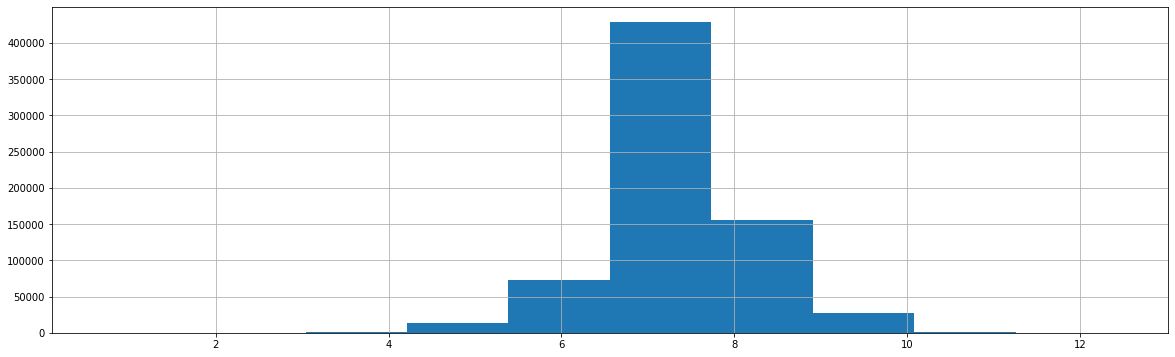

In [31]:
# RENDIMENTO
# Rendimento mensal em dinheiro que recebia normalmente,
# no mês de referência,
# no trabalho principal da semana de referência
df['renpri'] = np.where(df['c01012'] != 999999999999, df['c01012'], np.nan)
df['lnrenpri'] = np.log(df['renpri'])

# Cria um histogram de "renpri" 
df['lnrenpri'].hist(figsize=(20,6))

# Renda média mensal
df.groupby('mes')['renpri'].mean()

In [24]:
# Estatística descritiva
df[['mulher', 'homem', 'branca', 'negra', 'idpia', 'idquad', 'idpia4', 'anest', 'anest3', 'exp', 'expquad', 'urbano', 'rural']].describe()

,mulher,homem,branca,negra,idpia,idquad,idpia4,exp,expquad,urbano,rural
count,1.919883e+06,1.919883e+06,1.919409e+06,1.919409e+06,1.919883e+06,1.919883e+06,1.919883e+06,1.919883e+06,1.919883e+06,1.919883e+06,1.919883e+06
mean,5.204624e-01,4.795376e-01,4.237872e-01,5.723340e-01,3.689114e+01,1.837421e+03,2.424487e+00,2.824436e+01,1.266933e+03,7.615855e-01,2.384145e-01
std,4.995812e-01,4.995812e-01,4.941576e-01,4.947403e-01,2.182807e+01,1.793299e+03,1.666584e+00,2.166079e+01,1.479523e+03,4.261140e-01,4.261140e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.800000e+01,3.240000e+02,1.000000e+00,9.000000e+00,8.100000e+01,1.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.600000e+01,1.296000e+03,3.000000e+00,2.600000e+01,6.760000e+02,1.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.400000e+01,2.916000e+03,4.000000e+00,4.500000e+01,2.025000e+03,1.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.110000e+02,1.232100e+04,5.000000e+00,1.050000e+02,1.102500e+04,1.000000e+00,1.000000e+00


In [32]:
# Analisa estatísticas descritivas tempo da mulhar desempregada
df.groupby('desemp').agg({'mulher': 'count'})

# Analisa estatísticas por grupo
df.groupby('desemp').agg({'mulher': 'sum', 'negra': 'sum', 'anest3': 'sum'})
df[df['idpia']<10]['idpia'].sum()
df['renpri'].mean()

2231.6073128531225